In [1]:
import redshift_connector
import pandas as pd
import numpy as np
from decimal import Decimal
import atoti as tt

# Import Data from redshift

## -- set up connection

In [2]:
conn = redshift_connector.connect(
     host='redshift-cluster-1.chlxxjsyvqb3.us-east-1.redshift.amazonaws.com',
     port=5439,
     database='karabiner',
     user='admin',
     password='Password123'
  )
cursor = conn.cursor()

## -- retrieve data + schema

In [3]:
cursor.execute("select * from trade")
trade_df: pd.DataFrame = cursor.fetch_dataframe()

In [4]:
cursor.execute("SELECT * FROM pg_table_def WHERE tablename='trade'")
trade_schema: pd.DataFrame = cursor.fetch_dataframe()

In [5]:
cursor.execute("select * from cashflow")
cashflow_df: pd.DataFrame = cursor.fetch_dataframe()

In [6]:
cursor.execute("SELECT * FROM pg_table_def WHERE tablename='cashflow'")
cashflow_schema: pd.DataFrame = cursor.fetch_dataframe()

## -- prepare for cube

Transform Decimal type to double

In [7]:
def df_dec_to_double(df):
    for col in df.columns:
        if type(df[col].iloc[0]) == Decimal:
            df[col] = df[col].apply(lambda x: np.double(x))

In [8]:
df_dec_to_double(trade_df)
df_dec_to_double(cashflow_df)

Generate atoti data types from schema & replace column names

In [9]:
def get_type_config(df, schema, col_names):
    types = {}
    for index, col in enumerate(df.columns):
        row = schema.loc[schema['column'] == col]
        dtype = row['type'].iloc[0]
        required = row['notnull'].iloc[0]
        name = col_names[index]
        if dtype == 'date':
            if required == True:
                types[name] = tt.type.LOCAL_DATE
            else:
                types[name] = tt.type.NULLABLE_LOCAL_DATE
        elif dtype.startswith('character varying'):
            if required == True:
                types[name] = tt.type.STRING
            else:
                types[name] = tt.type.NULLABLE_STRING
        elif dtype.startswith('numeric'):
            if required == True:
                types[name] = tt.type.DOUBLE
            else:
                types[name] = tt.type.NULLABLE_DOUBLE
        elif dtype.startswith('timestamp'):
            if required == True:
                types[name] = tt.type.LOCAL_DATE_TIME
            else:
                types[name] = tt.type.NULLABLE_LOCAL_DATE_TIME
        elif dtype == 'integer' or dtype == 'bigint':
            if required == True:
                types[name] = tt.type.LONG
            else:
                types[name] = tt.type.NULLABLE_LONG
    return types

In [10]:
trade_columns = ['Date', 'Clearing Member Code', 'Clearing Member Short Name', '2nd Layer Type', '2nd Layer', '3rd Layer', 'Original Counterparty ID', 'Original Counterparty Name', 'Clearing House Trade Reference', 
                 'Internal Trade ID', 'Trade Group ID', 'Source', 'External Reference', 'Trade Date', 'Registration Date And Time', 'Maturity Date', 'Trade Status', 'Backload Flag', 'Currency', 'Notional Amount', 
                 'Swap Type', 'Trade Effective Date', 'Trade NPV', 'Stub At', 'Pay Leg Type', 'Pay Rate', 'Pay Spread', 'Pay Index', 'Pay Rate Index Tenor', 'Pay Day Count Fraction', 'Pay Payment Frequency', 
                 'Pay Business Day Convention', 'Pay Holiday Centers', 'Pay Calc Period Frequency', 'Pay Compounding Method', 'Pay Stub Type', 'Rec Leg Type', 'Rec Rate', 'Rec Spread', 'Rec Index', 'Rec Rate Index Tenor', 
                 'Rec Day Count Fraction', 'Rec Payment Frequency', 'Rec Business Day Convention', 'Rec Holiday Centers', 'Rec Calc Period Frequency', 'Rec Compounding Method', 'Rec Stub Type', 'Roll Date Convention', 
                 'Mutual Put Option Flag', 'Pay Stub Index Tenor', 'Pay Stub Index Tenor 2', 'Pay First Payment Date', 'Pay First Period Calc End Date', 'Pay Fixing Holiday Centers', 'Pay Fixing Days Offset', 
                 'Pay Reset In Arrears', 'Rec Stub Index Tenor', 'Rec Stub Index Tenor 2', 'Rec First Payment Date', 'Rec First Period Calc End Date', 'Rec Fixing Holiday Centers', 'Rec Fixing Days Offset', 
                 'Rec Reset In Arrears', 'Pay Initial Period Rate', 'Pay Initial Period Fix Lag', 'Pay Stub Rate', 'Pay Stub End Date', 'Pay Stub Fixed Amount', 'Rec Initial Period Rate', 'Rec Initial Period Fix Lag', 
                 'Rec Stub Rate', 'Rec Stub End Date', 'Rec Stub Fixed Amount', 'Roll Date', 'Additional Pay Date', 'Additional Pay Amount', 'NPV change', 'Unique Swap ID', 'Legal Entity ID', 
                 'Un-adjusted Trade Effective Date', 'Un-adjusted Maturity Date', 'Notional Amount Change Flag', 'Current Notional Amount', 'Mutual Put Break Date', 'Pay Payment Lag', 'Rec Payment Lag', 
                 'Execution Platform', 'Execution Platform Type', 'Netting Flag', 'PAI', 'External Reference (Child)']

trade_types = get_type_config(trade_df, trade_schema, trade_columns)
trade_df.columns = trade_columns

In [11]:
cashflow_columns = ['Date', 'Clearing Member Code', 'Clearing Member Short Name', '2nd Layer Type', '2nd Layer', '3rd Layer', 'Currency', 'Internal Trade ID', 'Clearing House Trade Reference', 'Type of Flow', 
                    'Payment Date', 'Calculation Days', 'NPV', 'Discount Factor', 'Cashflow Amount', 'Interest Calc Start Date', 'Interest Rate', 'Product Type', 'Notional Amount']

cashflow_types = get_type_config(cashflow_df, cashflow_schema, cashflow_columns)
cashflow_df.columns = cashflow_columns

Change empty string fields to N/A

In [12]:
def df_empty_str_to_na(df, type_dict):
    for col in type_dict:
        if type_dict[col] == tt.type.STRING or type_dict[col] == tt.type.NULLABLE_STRING:
            df[col] = df[col].apply(lambda x: 'N/A' if x == '' else x)

In [13]:
df_empty_str_to_na(trade_df, trade_types)
df_empty_str_to_na(cashflow_df, cashflow_types)

# Set up Cube

In [14]:
session = tt.create_session(
    name='Main session',
    config={
        'port': 34967,
        'user_content_storage': 'content'
    }
)
session.link()

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

## -- import data

Generate hierarchy columns list

In [15]:
def get_hierarchized_cols(type_dict):
    hc = []
    for col in type_dict:
        if (type_dict[col] == tt.type.BOOLEAN or type_dict[col] == tt.type.NULLABLE_BOOLEAN 
            or type_dict[col] == tt.type.STRING or type_dict[col] == tt.type.NULLABLE_STRING
            or type_dict[col] == tt.type.LOCAL_DATE or type_dict[col] == tt.type.NULLABLE_LOCAL_DATE 
            or type_dict[col] == tt.type.LOCAL_DATE_TIME or type_dict[col] == tt.type.NULLABLE_LOCAL_DATE_TIME
           ):
            hc.append(col)
    return hc

In [16]:
trade_hc = get_hierarchized_cols(trade_types)
cashflow_hc = get_hierarchized_cols(cashflow_types)

Create tables

In [17]:
trades_table = session.read_pandas(
    trade_df, 
    table_name='Trades', 
    keys=['Clearing House Trade Reference'], 
    types=trade_types,
    hierarchized_columns=trade_hc
)

In [18]:
flows_table = session.read_pandas(
    cashflow_df, 
    table_name='Flows', 
    keys=['Clearing House Trade Reference', 'Type of Flow', 'Payment Date'],
    types=cashflow_types,
    hierarchized_columns=cashflow_hc
)

In [19]:
flows_table.join(trades_table)

In [20]:
cube = session.create_cube(flows_table, 'Karabiner', mode='auto')

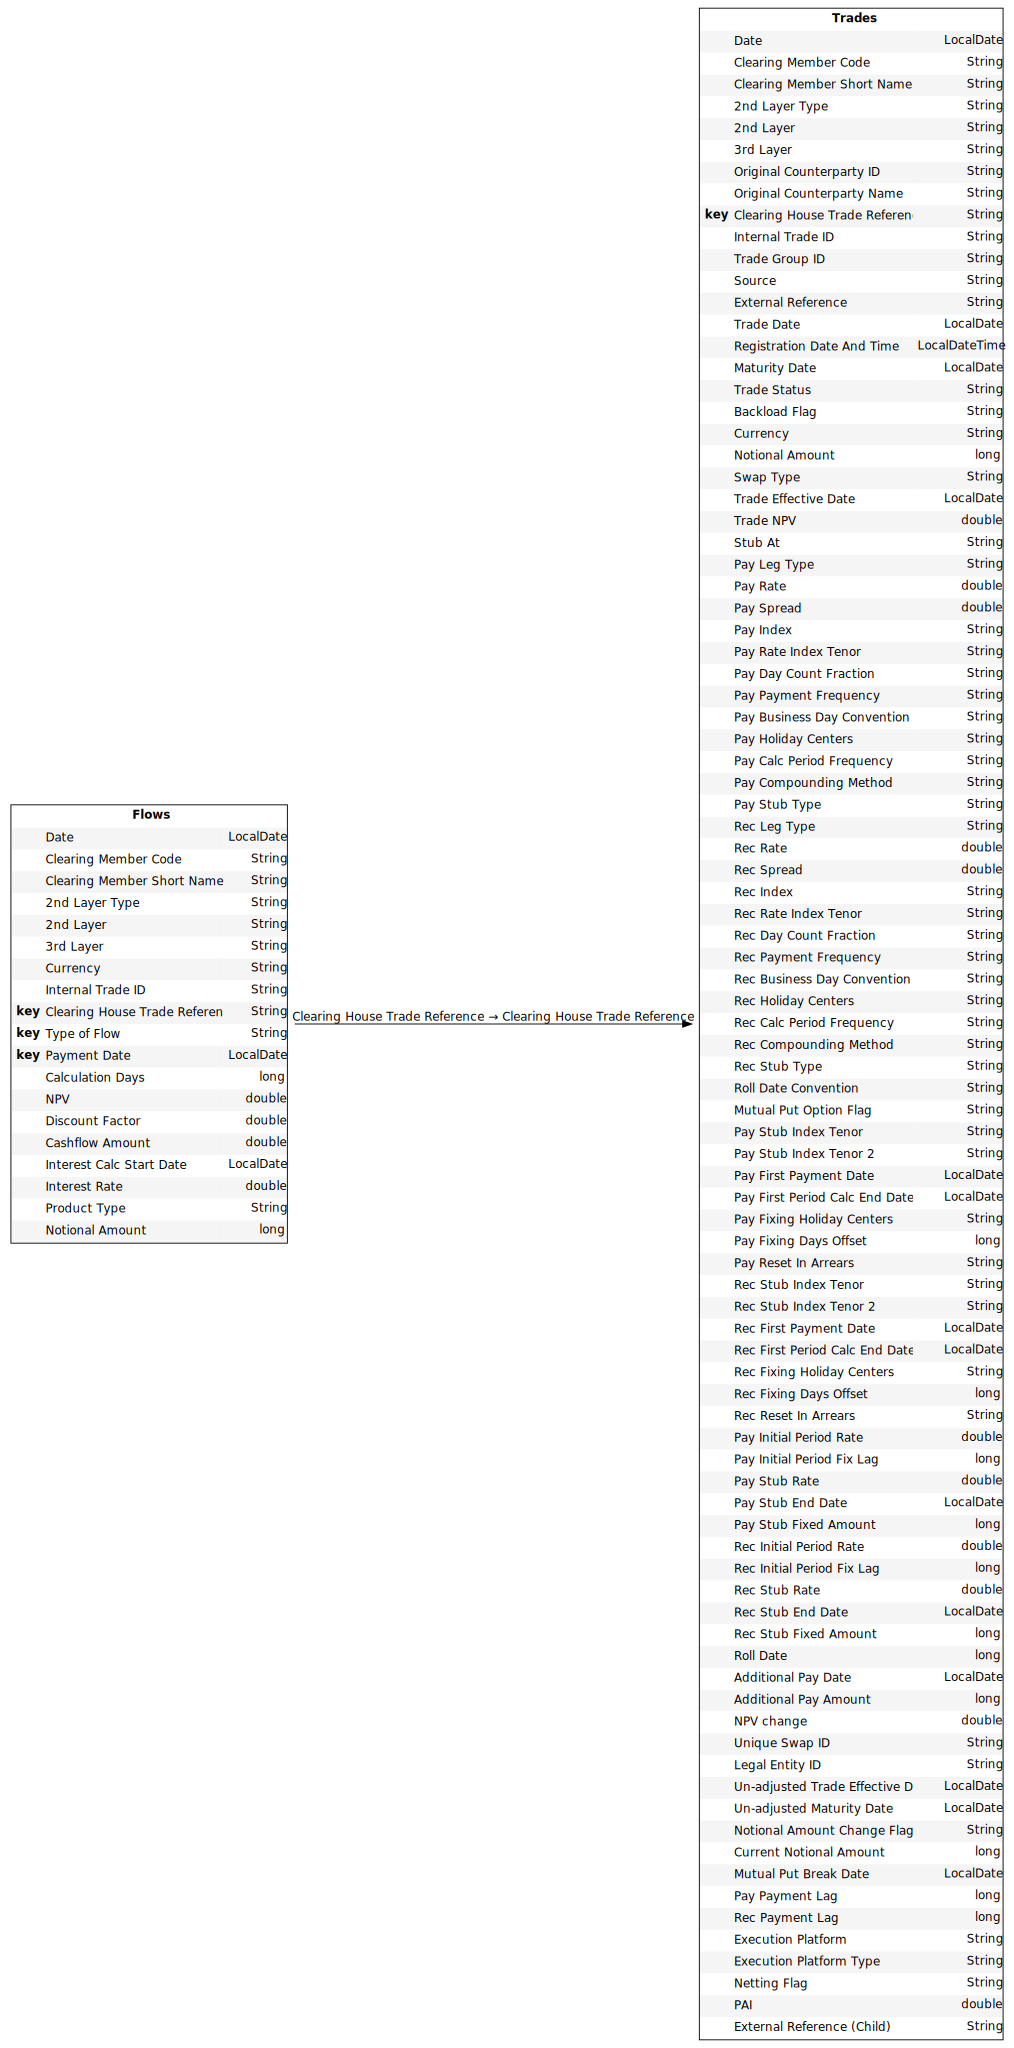

In [21]:
cube.schema

## -- create hierarchies

In [22]:
m, h, lvl = cube.measures, cube.hierarchies, cube.levels

In [23]:
m

Measures()

Sample multi-level date hierarchy (in addition to date single-level hierarchies)

In [24]:
cube.create_date_hierarchy('Payment Date Parts', column=flows_table['Payment Date'], levels={'Year': 'y', 'Month': 'M', 'Day': 'd'})

# Visualize

In [25]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [26]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.